In [75]:
import os.path
import math
import numpy as np
import matplotlib.pyplot as plt
from random import sample, shuffle
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer, LSTM, Multiply
from tensorflow.keras import Sequential, Model, Input
SR = 16000

## 1: Data Generator

In [50]:
class GenData(Sequence):
    def __init__(self, path, split='train', batch_size=32):
        # init
        self.batch_size = batch_size
        self.mode = split
        self.path = os.path.join(path, split)
        self.files = os.listdir(self.path)
        assert len(self.files) > 0, 'there is no file in this folder!'
        self.idx = np.random.permutation(len(self.files))


    def __len__(self):
        return math.floor(len(self.files)/self.batch_size)

    def __getitem__(self, item):
        assert len(self) >= item, 'item out of index range'
        assert item >=0, 'item has to be positive'
        features = []
        labels = []
        # load data
        # for file in self.files[item*self.batch_size:(item+1)*self.batch_size]:
        #     data = np.load(os.path.join(self.path, file), allow_pickle=True)
        #     self.features.append(data.f.features)
        #     self.labels.append(data.f.vad)

        for index in self.idx[item*self.batch_size:(item+1)*self.batch_size]:
            data = np.load(os.path.join(self.path, self.files[index]), allow_pickle=True)
            features.append(data.f.features)
            labels.append(data.f.vad)

        # find length of shortest data sequence and truncate raw data
        self.smallest_length = min([np.shape(elem)[1] for elem in features])
        features[:] = (data[:, :self.smallest_length] for data in features)
        labels[:] = (data[:self.smallest_length] for data in labels)
        features = np.transpose(features, (0, 2, 1))
        labels = np.expand_dims(labels, axis=-1)
        return features, np.round(labels)

    def on_epoch_end(self):
        # files list
        if self.mode == 'train':
            # self.files = np.random.permutation(self.files)
            self.idx = np.random.permutation(self.idx)

        # data = list(zip(self.features, self.labels))
        # shuffle(data)
        # self.features, self.labels = zip(*data)

In [51]:
# Instantiate one generator for training, validation and test data
path = './'
val_genData = GenData(path, split='val', batch_size=16)
train_genData = GenData(path, split='train', batch_size=16)
test_genData = GenData(path, split='test', batch_size=16)

In [52]:
# Draw a batch from the training generator, and verify that the samples have the correct shape.
train_data, train_label = test_genData.__getitem__(2)
print(np.shape(train_data))
print(np.shape(train_label))

(16, 237, 62)
(16, 237, 1)


## 2: First Experiment

In [53]:
# In the function build_model construct and compile the following neural network.
# It is intended to predict the probability of speech being present.

# from tensorflow.keras....
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

def build_model():
    model = Sequential()
    model.add(InputLayer((None, 62)))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.01)
    loss = BinaryCrossentropy()
    acc = BinaryAccuracy()
    model.compile(optimizer=opt, loss=loss, metrics=[acc])

    return model

In [54]:
# Train the model for 10 epochs and store the training history.
model = build_model()
print(model.summary())
history =  model.fit(train_genData, validation_data=val_genData, epochs=10)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, None, 62)          248       
_________________________________________________________________
dense_18 (Dense)             (None, None, 32)          2016      
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 32)          128       
_________________________________________________________________
dense_19 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 32)          128       
_________________________________________________________________
dense_20 (Dense)             (None, None, 1)           33        
Total params: 3,609
Trainable params: 3,357
Non-trainable params: 252
__________________________________________________

## 3: Evaluation

50/50 [==============================] - 3s 57ms/step - loss: 0.3247 - binary_accuracy: 0.8600 - ETA: 4s - loss: 0.2914 - binary_accuracy: 0.8808

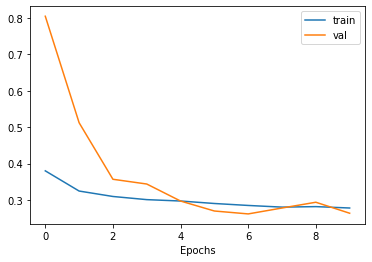

In [58]:
model.evaluate(test_genData)
# Compute and display the metrics on the test set
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.legend()
plt.show()

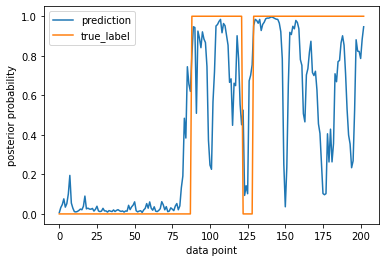

In [63]:
# Select a sentence from the test set and plot the true targets and the network’s predictions in one diagram.

def plot_example(mdl, gen):
    '''
        mdl: model
        gen: Generator
    '''

    data, label = gen.__getitem__(3)
    acc_test = mdl.predict(data)
    plt.plot(acc_test[0], label='prediction')
    plt.plot(label[0], label='true_label')
    plt.xlabel('data point')
    plt.ylabel('posterior probability')
    plt.legend()
    plt.show()

plot_example(model, test_genData)

## 4: Gated Activation Functions

In [78]:
def build_gated_model():
    netin = Input((None, 62))
    norm = BatchNormalization()(netin)
    tanh = Dense(32, activation='tanh')(norm)
    sigmoid = Dense(32, activation='sigmoid')(norm)
    multi = Multiply()([tanh, sigmoid])
    norm2 = BatchNormalization()(multi)
    output = Dense(1, activation='sigmoid')(norm2)

    opt = Adam(learning_rate=0.01)
    loss = BinaryCrossentropy()
    acc = BinaryAccuracy()

    resnet = Model(inputs=netin, outputs=output)
    resnet.compile(optimizer=opt, loss=loss, metrics=[acc])

    return resnet

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, 62)]   0                                            
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, None, 62)     248         input_14[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, None, 32)     2016        batch_normalization_34[0][0]     
__________________________________________________________________________________________________
dense_34 (Dense)                (None, None, 32)     2016        batch_normalization_34[0][0]     
____________________________________________________________________________________________

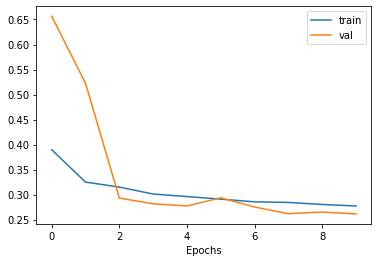

In [79]:
# fit and evaluate
model = build_gated_model()
print(model.summary())
history =  model.fit(train_genData, validation_data=val_genData, epochs=10)
model.evaluate(test_genData)
# Compute and display the metrics on the test set
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## 5: A Recurrent Network

In [88]:
def build_rnn():
    netin = Input((None, 62))
    x = BatchNormalization()(netin)
    x = LSTM(32, activation='relu', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LSTM(32, activation='relu', return_sequences=True)(x)
    x = BatchNormalization()(x)
    output = Dense(1, activation='sigmoid')(x)

    opt = Adam(learning_rate=0.01)
    loss = BinaryCrossentropy()
    acc = BinaryAccuracy()
    resnet = Model(inputs=netin, outputs=output)
    resnet.compile(optimizer=opt, loss=loss, metrics=[acc])

    return model

In [89]:
# train the model
model = build_rnn()
print(model.summary())
history_rnn =  model.fit(train_genData, validation_data=val_genData, epochs=5)
model.evaluate(test_genData)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, 62)]   0                                            
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, None, 62)     248         input_14[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, None, 32)     2016        batch_normalization_34[0][0]     
__________________________________________________________________________________________________
dense_34 (Dense)                (None, None, 32)     2016        batch_normalization_34[0][0]     
____________________________________________________________________________________________

[0.31640374660491943, 0.8693661689758301]

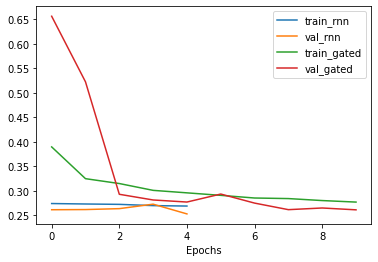

In [90]:
# Plot the training and validation loss for the RNN and the network from exercise 1.4 in one diagram.
# Compute and display the metrics on the test set
plt.plot(history_rnn.history['loss'], label='train_rnn')
plt.plot(history_rnn.history['val_loss'], label='val_rnn')
plt.plot(history.history['loss'], label='train_gated')
plt.plot(history.history['val_loss'], label='val_gated')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# Plot the recurrent networks prediction for the previously chosen instance from the test set.



## 6: Batch Size

In [94]:
for batch_size in [4, 8, 16, 32, 64, 128]:
    print('Batch size: ' + str(batch_size))
    train_genData = GenData(path, split='train', batch_size=batch_size)
    model = build_rnn()
    history_rnn =  model.fit(train_genData, validation_data=GenData(path, split='val', batch_size=batch_size), epochs=1)
    model.evaluate(test_genData)

Batch size: 4
50/50 [==============================] - 2s 41ms/step - loss: 0.3065 - binary_accuracy: 0.8734

## Optional: 7: Hyperparameter Tuning

In [ ]:
from kerastuner import HyperParameters

def hypermodel(hp: HyperParameters):
    pass

In [ ]:
import kerastuner as kt
from shutil import rmtree


